In [6]:
from langchain_community.document_loaders.csv_loader import CSVLoader
import pandas as pd
from IPython.display import Markdown
import re

from typing import Annotated, Literal
from typing_extensions import TypedDict
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.tools.retriever import create_retriever_tool
from langchain.document_loaders import PyMuPDFLoader, PyPDFLoader
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.tools import tool
from langchain_core.documents.base import Document
from langchain_core.vectorstores.base import VectorStoreRetriever
from langchain_core.output_parsers.openai_tools import JsonOutputToolsParser
from langchain_core.output_parsers.string import StrOutputParser
from langchain.schema.runnable import RunnablePassthrough, RunnableLambda
from langchain_experimental.utilities import PythonREPL
from langchain_experimental.tools.python.tool import PythonAstREPLTool
from pydantic import BaseModel, Field
from markitdown import MarkItDown
import dotenv
import os

dotenv.load_dotenv()

True

In [67]:
# file_path = "./data/athlete_events.csv"
file_path = "./data/titanic.csv"

llm = ChatOpenAI(model="gpt-4o-mini",
                 temperature=0.,)

In [92]:
class State(TypedDict):
    query : Annotated[str, "User Question"]
    answer : Annotated[str, "LLM Response"]
    df : Annotated[pd.DataFrame, "Dataset"]
    title : Annotated[str, "Dataset Title"]
    summary : Annotated[str, "Dataset Summary"]
    tool : Annotated[PythonAstREPLTool, "Code Execute Tool"]
    code : Annotated[str, "Python Code"]

In [93]:
def check_tools(state:State):

    print("tool" in state)
    print("df" in state)

    print(state)
    
    if "tool" in state and "df" in state:
        return "continue"
    else:
        return "new"

In [94]:
def setup(state:State):
    df = pd.read_csv(file_path)

    print("===== 데이터프레임 생성 완료 =====\n\n")

    df_sampled = df.sample(n=5000) if len(df) > 5000 else df

    prompt = PromptTemplate.from_template("""
            당신은 요약 전문가입니다.
           
            데이터셋 : {df}

            데이터셋의 정보를 보고 제목과 요약을 만들어냅니다.
            제목은 이 데이터셋을 가장 잘 표현할 수 있는 제목으로 결정하여야합니다.

            참고할 정보는 아래와 같습니다.
            """
            f"""                                          
            파일 이름 : {file_path.split("/")[-1]}

            1. 제목: 
            2. 요약: 

            """
            )
    
    chain = prompt | llm
    
    result = chain.invoke({"df":df_sampled}).content

    title = "Untitled"
    summary = "No Summary"    

    try:
        lines = result.split("\n")
        title = lines[0].replace("1. 제목: ", "").strip()
        summary = "\n".join(lines[1:]).replace("2. 요약:", "").strip()
    except:
        pass

    print("===== 제목, 요약 생성 완료 =====\n\n")

    tool = PythonAstREPLTool(name="python_repl_ast", 
                        description="A Python shell. Use this to execute python commands. \
                                    Input should be a valid python command. When using this tool, \
                                    sometimes output is abbreviated - make sure it does not look abbreviated before using it in your answer.",
                        locals={"df":df})    

    print("===== 코드 툴 생성 완료 =====\n\n")

    return {"df" : df,
            "title" : title,
            "summary" : summary,
            "tool" : tool}

In [95]:
def init_state(state:State):
    df = pd.read_csv(file_path)

    print("===== Init Complete =====\n\n")
    
    return {"df" : df}

In [96]:
def create_title_summary(state:State):

    df_sampled = state["df"].sample(n=5000) if len(state["df"]) > 5000 else state["df"]

    prompt = PromptTemplate.from_template("""
            당신은 요약 전문가입니다.
           
            데이터셋 : {df}

            데이터셋의 정보를 보고 제목과 요약을 만들어냅니다.
            제목은 이 데이터셋을 가장 잘 표현할 수 있는 제목으로 결정하여야합니다.

            참고할 정보는 아래와 같습니다.
            """
            f"""                                          
            파일 이름 : {file_path.split("/")[-1]}

            1. 제목: 
            2. 요약: 

            """
            )
    
    chain = prompt | llm
    
    result = chain.invoke({"df":df_sampled}).content

    title = "Untitled"
    summary = "No Summary"    

    try:
        lines = result.split("\n")
        title = lines[0].replace("1. 제목: ", "").strip()
        summary = "\n".join(lines[1:]).replace("2. 요약:", "").strip()
    except:
        pass

    print("===== 제목, 요약 생성 완료 =====\n\n")
    return {"title":title, 
            "summary" :summary}

In [97]:
def create_tools(state:State):
    tool = PythonAstREPLTool(name="python_repl_ast", 
                        description="A Python shell. Use this to execute python commands. \
                                    Input should be a valid python command. When using this tool, \
                                    sometimes output is abbreviated - make sure it does not look abbreviated before using it in your answer.",
                        locals={"df":state["df"]})
    
    print("===== Code Tool Complete =====\n\n")

    return {"tool" : tool}

In [98]:
def create_code(state:State):
    
    prompt = ChatPromptTemplate([
        ("system", """당신은 pandas, matplotlib 라이브러리를 사용할 수 있는 전문가입니다. 주어진 df의 형태를 참고하여 코드를 작성합니다. \
                    다음은 `print(df.head())`의 형태입니다. {head}
        
                    ### 예시1
                    ```python
        
                    len(df)
                    ```
                    ### 예시2
                    ```python
        
                    # sum_gamerounds에 대한 히스토그램
                    plt.figure(figsize=(12, 6))
                    plt.barplot(df['sum_gamerounds'], bins=10, kde=True)
                    plt.title('Distribution of Sum Gamerounds')
                    plt.xlabel('Sum Gamerounds')
                    plt.ylabel('Frequency')
                    plt.grid()
                    plt.show()
                    ```
         
                    ### 주의할 점
                    1. seaborn은 사용하지 않습니다.
        
        """),
        ("human", "{query}")
    ])        
    
    chain = prompt | llm

    print("===== 코드 템플릿 생성 완료 =====\n\n")

    return {"answer" : chain.invoke({
        "head" : state["df"].head(),
        "query" : state["query"]
    })}

In [99]:
def extract_code(state:State):

    content = state["answer"].content

    try:
        code = re.findall(r'```python\n(.*?)\n```', content, re.DOTALL)[0]

        return {"code" : code}
    except:
        return {"code" : ""}

In [100]:
def execute_code(state:State):
    try:
        state["tool"].invoke(state["code"])

        return state
    except:
        print("코드를 실행하지 못했습니다.")

        return state
    

In [ ]:
def response_llm(state:State):

    if state["code"] == "":
        prompt = ChatPromptTemplate([
            ("system", """ 당신은 인사이트를 제공해주는는 데이터 분야 10년차 전문가입니다.
             이전 답변과 정보를 기반으로 질문에 대해 답변합니다.
            
             제목 : {title}            
             요약 : {summary}

             답변 : "{answer}"
            
            """),
            ("human", "{query}")
        ])        
        
        chain = prompt | llm

        answer = chain.invoke({
            "title" : state["title"],
            "summary" : state["summary"],
            "answer" : state["answer"],
            "query" : state["query"]
        })

        return {"answer" : answer}

    else:
        prompt = ChatPromptTemplate([
            ("system", """당신은 주어진 시각화 차트를 해석하고 인사이트를 제공하는 데이터 분야 10년차 전문가입니다.
            
            친절하고 상세하게 해당 시각화 차트를 설명해주세요.
            단, 코드를 설명하는 것이 아닙니다.
            숫자를 물어본다면 정확한 숫자까지 이야기하세요.

            제목 : {title}
            요약 : {summary}

            code : {code}
            """),
            ("human", "{query}")
        ])        
        
        chain = prompt | llm
        
        answer = chain.invoke({
            "title" : state["title"],
            "summary" : state["summary"],
            "code" : state["code"],
            "query" : state["query"]
        })

        return {"answer" : answer}

In [102]:
def pretty_print(state:State):

    print("\n\n===== Result =====\n\n")

    print(state["answer"].content)
    
    return state

In [103]:
# class intersection(BaseModel):
#     """
#     당신은 도구의 실행을 결정하는 어시스턴트입니다.
#     코드를 실행시켜야하는 경우라면 'tool' 이라고 답변하고 아닌 경우 'llm'라고 답변하세요.
#     """

#     binary_score : Literal["tool", "llm"] = Field(..., description="""You are the assistant in charge of determining the execution of the tool.
# Answer 'tool' if you need to run the code and 'llm' if you don't.""")

In [104]:
graph_builder = StateGraph(State)

In [105]:
# graph_builder.add_node("init state", init_state)
# graph_builder.add_node("create_title_summary", create_title_summary)
# graph_builder.add_node("create_tools", create_tools)
# graph_builder.add_node("create_code", create_code)
# graph_builder.add_node("extract_code", extract_code)
# graph_builder.add_node("execute_code", execute_code)
# graph_builder.add_node("response_llm", response_llm)
# graph_builder.add_node("pretty_print", pretty_print)

# graph_builder.add_edge(START, "init state")
# graph_builder.add_edge("init state", "create_title_summary")
# graph_builder.add_edge("create_title_summary", "create_tools")
# graph_builder.add_edge("create_tools", "create_code")
# graph_builder.add_edge("create_code", "extract_code")
# graph_builder.add_edge("extract_code", "execute_code")
# graph_builder.add_edge("execute_code", "response_llm")
# graph_builder.add_edge("response_llm", "pretty_print")
# graph_builder.add_edge("pretty_print", END);

In [106]:
# graph_builder.add_node("check_tools", check_tools)
graph_builder.add_node("setup", setup)
# graph_builder.add_node("init state", init_state)
# graph_builder.add_node("create_title_summary", create_title_summary)
# graph_builder.add_node("create_tools", create_tools)
graph_builder.add_node("create_code", create_code)
graph_builder.add_node("extract_code", extract_code)
graph_builder.add_node("execute_code", execute_code)
graph_builder.add_node("response_llm", response_llm)
graph_builder.add_node("pretty_print", pretty_print)

graph_builder.add_conditional_edges(START,
                                    check_tools,
                                    {"new":"setup",
                                     "continue":"create_code"}
                                     )
graph_builder.add_edge("setup", "create_code")
graph_builder.add_edge("create_code", "extract_code")
graph_builder.add_edge("extract_code", "execute_code")
graph_builder.add_edge("execute_code", "response_llm")
graph_builder.add_edge("response_llm", "pretty_print")
graph_builder.add_edge("pretty_print", END);

In [107]:
graph = graph_builder.compile()

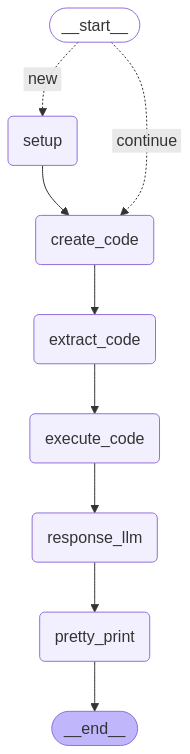

In [108]:
graph

===== 데이터프레임 생성 완료 =====


===== 제목, 요약 생성 완료 =====


===== 코드 툴 생성 완료 =====


===== 코드 템플릿 생성 완료 =====




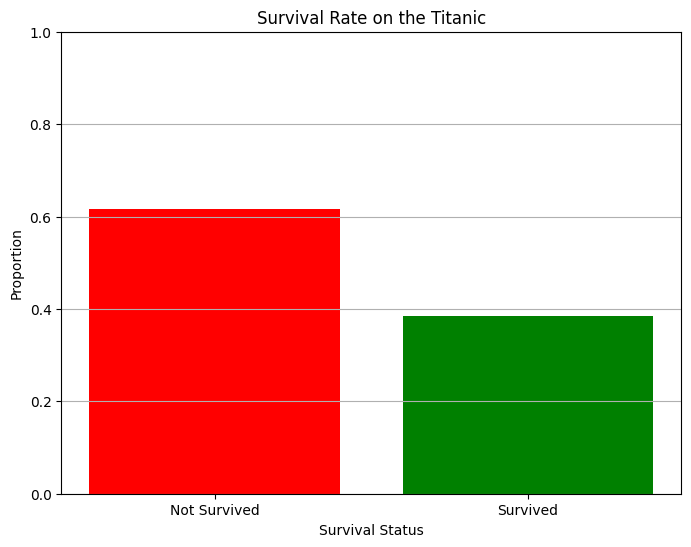

생존자 비율: 38.38%


===== Result =====


제목: **타이타닉 생존자 비율 시각화**

이 시각화는 타이타닉 호에서의 생존자와 사망자의 비율을 보여줍니다. 차트는 두 개의 바로 구성되어 있으며, 각각 생존 여부에 따라 '생존하지 않은 경우(Not Survived)'와 '생존한 경우(Survived)'를 나타냅니다. 

- **생존하지 않은 경우(Not Survived)**: 이 바는 빨간색으로 표시되어 있으며, 전체 승객 중 생존하지 못한 비율을 나타냅니다.
- **생존한 경우(Survived)**: 이 바는 초록색으로 표시되어 있으며, 전체 승객 중 생존한 비율을 나타냅니다.

차트의 Y축은 생존 비율을 0에서 1까지의 범위로 설정하여, 각 생존 상태의 비율을 직관적으로 비교할 수 있도록 하였습니다. X축은 생존 상태를 나타내며, 각 바의 높이는 해당 상태의 비율을 나타냅니다. 

이 시각화를 통해 다음과 같은 인사이트를 얻을 수 있습니다:

1. **생존자 비율**: 전체 승객 중 약 38.38%가 생존하였음을 알 수 있습니다. 이는 타이타닉 호의 비극적인 사고에서 생존한 승객의 비율을 나타내며, 생존자 수가 상대적으로 적다는 것을 보여줍니다.

2. **사망자 비율**: 반면, 약 61.62%의 승객이 사망하였음을 나타냅니다. 이는 사고의 심각성을 강조하며, 많은 승객이 구조되지 못했음을 시사합니다.

이 데이터는 생존율 분석 및 다양한 인구 통계적 요인과의 관계를 연구하는 데 중요한 기초 자료가 될 수 있습니다. 예를 들어, 생존자와 사망자의 성별, 나이, 객실 등급 등의 특성을 추가적으로 분석하면, 생존에 영향을 미친 요인들을 더 깊이 이해할 수 있을 것입니다.


In [85]:
invoke_result = graph.invoke({"query": "생존자의 비율 시각화하고 인사이트 제공해줘."})

False
False
{'query': '성별 비율 알려줘'}
===== 데이터프레임 생성 완료 =====


===== 제목, 요약 생성 완료 =====


===== 코드 툴 생성 완료 =====


===== 코드 템플릿 생성 완료 =====




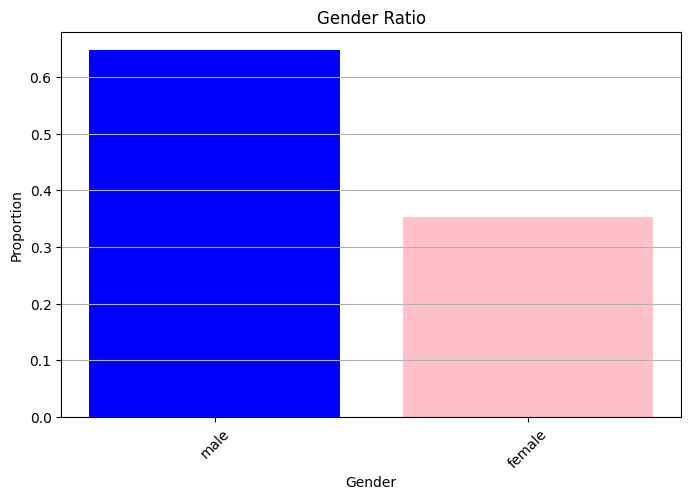



===== Result =====


제공된 시각화 차트는 타이타닉 승객의 성별 비율을 나타내고 있습니다. 이 차트는 두 가지 성별, 즉 남성과 여성의 비율을 비교하는 바 차트 형태로 구성되어 있습니다.

1. **성별 비율**: 차트에서 남성과 여성의 비율이 각각 어떻게 분포되어 있는지를 보여줍니다. 일반적으로 타이타닉 승객 데이터셋에서는 남성이 여성보다 더 많은 비율을 차지하는 경향이 있습니다. 이 비율은 생존율 분석에 중요한 요소로 작용할 수 있습니다.

2. **색상 구분**: 남성은 파란색, 여성은 분홍색으로 표시되어 있어 시각적으로 쉽게 구분할 수 있습니다. 이러한 색상 구분은 데이터의 이해를 돕고, 각 성별의 비율을 직관적으로 파악할 수 있게 합니다.

3. **비율의 해석**: 차트의 Y축은 각 성별의 비율을 나타내며, 이 비율은 0과 1 사이의 값으로 표현됩니다. 예를 들어, 만약 남성이 0.6, 여성이 0.4로 나타난다면, 이는 전체 승객 중 60%가 남성이고 40%가 여성이라는 것을 의미합니다.

4. **추가적인 인사이트**: 성별 비율은 생존율과 밀접한 관계가 있을 수 있습니다. 역사적으로 타이타닉 사고에서 여성과 어린이의 생존율이 남성보다 높았다는 점을 고려할 때, 이 성별 비율은 생존 분석에 중요한 기초 데이터를 제공합니다.

이 차트를 통해 타이타닉 승객의 성별 분포를 명확히 이해할 수 있으며, 이는 이후의 생존율 분석 및 인구 통계적 연구에 중요한 기초 자료로 활용될 수 있습니다.


In [109]:
invoke_result2 = graph.invoke({"query": "성별 비율 알려줘"})